In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [2]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [3]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [4]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]} + C * \epsilon
$$


Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавай свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. На выходе должен получиться датасет того же размера с измененными категориальными признаками

In [9]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric):
        
        ### Your code is here
        self.categorical = categorical
        self.numeric = numeric
    
    def fit(self, X, y):

        ### Your code is here
        X_fit = X.copy()
        y_fit = y.copy()
        
        X_with_target = pd.concat((X_fit, y_fit), axis=1)
        ### Посчитаем на валидации средние значения таргета
        self.dict_of_means = {col : X_with_target.groupby(col)[y_fit.name].mean()+np.random.normal()*0.006
                              for col in self.categorical}
#         self.dict_of_means = {col : X_with_target.groupby(col)[y_fit.name].mean()+np.random.normal(0,1,len(X_with_target.groupby(col)[y_fit.name]))*0.006
#                               for col in self.categorical}
        
        return self
        
    def transform(self, df):
        
        ### Your code is here
        X_ = df.copy()
        for col in self.categorical:
                X_[col] = X_[col].map(self.dict_of_means[col])
                
                #mean_value = transformer.dict_of_means[col].values.mean()
                
                #X_[col] = X_[col].fillna(mean_value)
                X_[col] = X_[col].fillna(0)
        
        return X_[sorted(X_.columns)]

In [43]:
### Проверка работы трансформера

np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train.head()

,fuel,km_driven,name,owner,seller_type,transmission,year
3294,13.085954,50000,13.478865,12.959126,12.611658,13.776443,13.435892
2290,12.450179,70000,12.125200,12.959126,12.611658,13.776443,11.906484
874,12.450179,50000,12.311508,12.959126,12.611658,12.643381,13.333058
1907,12.450179,92198,12.493842,12.446379,13.140882,12.643381,13.053677
3244,12.450179,3240,12.401697,12.446379,12.611658,12.643381,12.857085


Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [44]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

0.7968292144892041


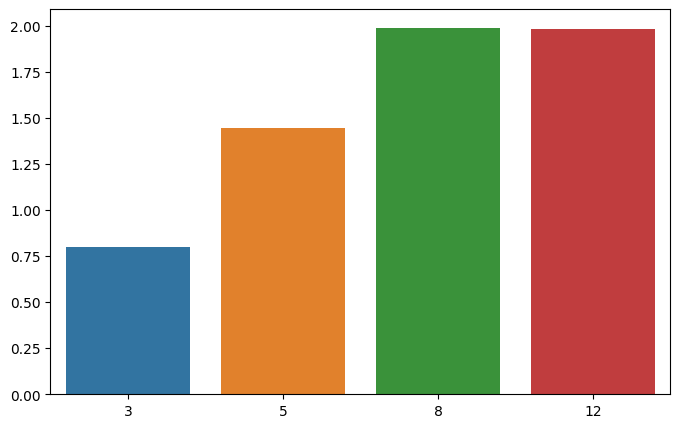

In [45]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

np.random.seed(1)

### Your code is here
MSE=[]
for depth in max_depth_list:
    pipe = Pipeline([("MeanTargetEncoderNoise",
                  MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(max_depth=depth))])

    pipe.fit(X_train, y_train)
    MSE.append(mse(y_test, pipe.predict(X_test)))
    
print(min(MSE))

    
fig = plt.figure()
fig.set_size_inches(8, 5)

sns.barplot(x=max_depth_list,
            y=MSE)


plt.show()






0.8076747956646494


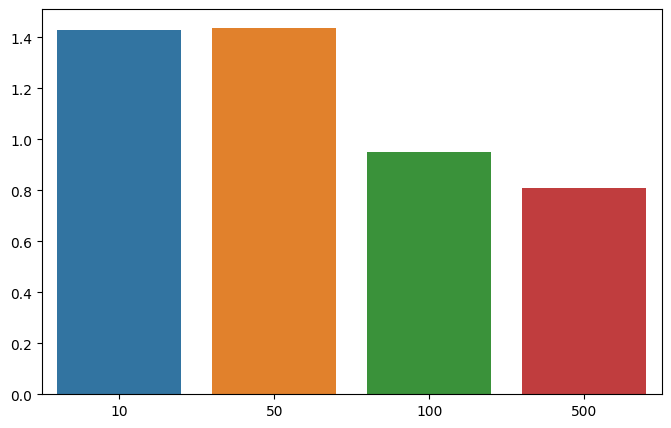

In [46]:
MSE=[]
for samples_split in min_samples_split_list:
    pipe = Pipeline([("MeanTargetEncoderNoise",
                  MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(min_samples_split=samples_split))])

    pipe.fit(X_train, y_train)
    MSE.append(mse(y_test, pipe.predict(X_test)))

print(min(MSE))
    
fig = plt.figure()
fig.set_size_inches(8, 5)

sns.barplot(x=min_samples_split_list,
            y=MSE)


plt.show()

0.5204871413036208


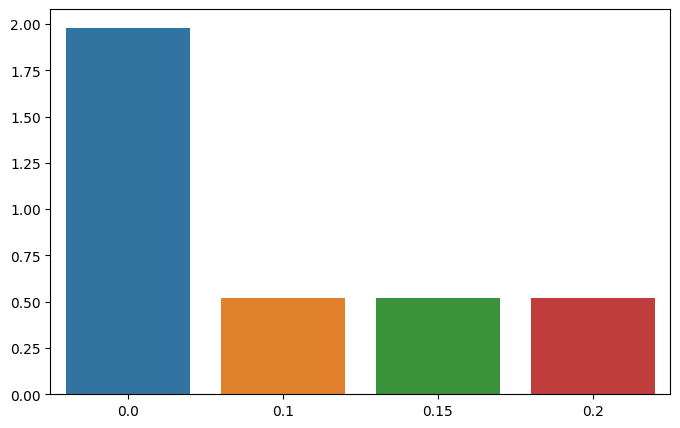

In [47]:
MSE=[]
for impurity_decrease in min_impurity_decrease_list:
    pipe = Pipeline([("MeanTargetEncoderNoise",
                  MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(min_impurity_decrease=impurity_decrease))])

    pipe.fit(X_train, y_train)
    MSE.append(mse(y_test, pipe.predict(X_test)))

print(min(MSE))
    
fig = plt.figure()
fig.set_size_inches(8, 5)

sns.barplot(x=min_impurity_decrease_list,
            y=MSE)


plt.show()

1.978382930534648


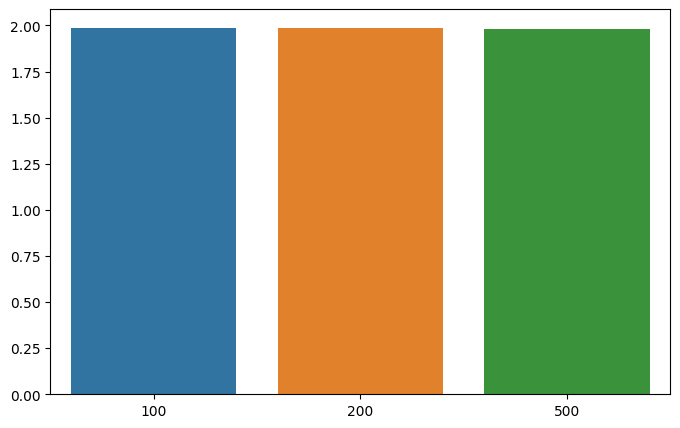

In [48]:
MSE=[]
for leaf_nodes in max_leaf_nodes_list:
    pipe = Pipeline([("MeanTargetEncoderNoise",
                  MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(max_leaf_nodes=leaf_nodes))])

    pipe.fit(X_train, y_train)
    MSE.append(mse(y_test, pipe.predict(X_test)))

print(min(MSE))
    
fig = plt.figure()
fig.set_size_inches(8, 5)

sns.barplot(x=max_leaf_nodes_list,
            y=MSE)


plt.show()

In [49]:
MSE

[1.9883090342277725, 1.9839205320539335, 1.978382930534648]

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [51]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
splitter = TimeSeriesSplit(n_splits=3)

param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

### Your code is here


search = GridSearchCV(pipe, 
                      param_grid, 
                      cv=splitter,
                      scoring='neg_mean_squared_error',
                      verbose=10)

search.fit(X_train, y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test)}")



Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV 1/3; 1/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 1/3; 1/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.796 total time=   0.0s
[CV 2/3; 1/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 2/3; 1/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.401 total time=   0.0s
[CV 3/3; 1/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 3/3; 1/192] END decision_tree__max_depth=3, decision_tree__max_l

[CV 2/3; 9/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.713 total time=   0.0s
[CV 3/3; 9/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10
[CV 3/3; 9/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.539 total time=   0.0s
[CV 1/3; 10/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50
[CV 1/3; 10/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.783 total time=   0.0s
[CV 2/3; 10/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=1

[CV 3/3; 18/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-0.889 total time=   0.0s
[CV 1/3; 19/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 1/3; 19/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.802 total time=   0.0s
[CV 2/3; 19/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 2/3; 19/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.401 total time=   0.0s
[CV 3/3; 19/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, deci

[CV 3/3; 27/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.539 total time=   0.0s
[CV 1/3; 28/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500
[CV 1/3; 28/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.783 total time=   0.0s
[CV 2/3; 28/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500
[CV 2/3; 28/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.713 total time=   0.0s
[CV 3/3; 28/192] START decision_tree__max_depth=3, decision_tree__max_leaf

[CV 3/3; 36/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.657 total time=   0.0s
[CV 1/3; 37/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 1/3; 37/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.783 total time=   0.0s
[CV 2/3; 37/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 2/3; 37/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.713 total time=   0.0s
[CV 3/3; 37/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500,

[CV 1/3; 46/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.783 total time=   0.0s
[CV 2/3; 46/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 2/3; 46/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.713 total time=   0.0s
[CV 3/3; 46/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 3/3; 46/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.539 total time=   0.0s
[CV 1/3; 47/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500

[CV 1/3; 55/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.783 total time=   0.0s
[CV 2/3; 55/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100
[CV 2/3; 55/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.713 total time=   0.0s
[CV 3/3; 55/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100
[CV 3/3; 55/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.539 total time=   0.0s
[CV 1/3; 56/192] START decision_tree__max_depth=5, decision_tree__max_leaf_node

[CV 1/3; 64/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.783 total time=   0.0s
[CV 2/3; 64/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500
[CV 2/3; 64/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.713 total time=   0.0s
[CV 3/3; 64/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500
[CV 3/3; 64/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.539 total time=   0.0s
[CV 1/3; 65/192] START decision_tree__max_depth=5, decision_tree__max_leaf_node

[CV 1/3; 73/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.783 total time=   0.0s
[CV 2/3; 73/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10
[CV 2/3; 73/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.713 total time=   0.0s
[CV 3/3; 73/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10
[CV 3/3; 73/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.539 total time=   0.0s
[CV 1/3; 74/192] START decision_tree__max_depth=5, decision_tree__max_leaf_node

[CV 2/3; 82/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.876 total time=   0.0s
[CV 3/3; 82/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50
[CV 3/3; 82/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.158 total time=   0.0s
[CV 1/3; 83/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 1/3; 83/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.794 total time=   0.0s
[CV 2/3; 83/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decisi

[CV 2/3; 91/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.713 total time=   0.0s
[CV 3/3; 91/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100
[CV 3/3; 91/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.539 total time=   0.0s
[CV 1/3; 92/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500
[CV 1/3; 92/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.783 total time=   0.0s
[CV 2/3; 92/192] START decision_tree__max_depth=5, decision_tree__max_leaf

[CV 2/3; 100/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-1.017 total time=   0.0s
[CV 3/3; 100/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500
[CV 3/3; 100/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.653 total time=   0.0s
[CV 1/3; 101/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 1/3; 101/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.783 total time=   0.0s
[CV 2/3; 101/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=

[CV 2/3; 109/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.713 total time=   0.0s
[CV 3/3; 109/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10
[CV 3/3; 109/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.539 total time=   0.0s
[CV 1/3; 110/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 1/3; 110/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.783 total time=   0.0s
[CV 2/3; 110/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nod

[CV 2/3; 118/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.713 total time=   0.0s
[CV 3/3; 118/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50
[CV 3/3; 118/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.539 total time=   0.0s
[CV 1/3; 119/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100
[CV 1/3; 119/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.783 total time=   0.0s
[CV 2/3; 119/192] START decision_tree__max_depth=8, decision_tree__max_leaf_n

[CV 2/3; 127/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.713 total time=   0.0s
[CV 3/3; 127/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100
[CV 3/3; 127/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.539 total time=   0.0s
[CV 1/3; 128/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500
[CV 1/3; 128/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.783 total time=   0.0s
[CV 2/3; 128/192] START decision_tree__max_depth=8, decision_tree__max_lea

[CV 2/3; 136/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.713 total time=   0.0s
[CV 3/3; 136/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500
[CV 3/3; 136/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.539 total time=   0.0s
[CV 1/3; 137/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10
[CV 1/3; 137/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.783 total time=   0.0s
[CV 2/3; 137/192] START decision_tree__max_depth=8, decision_tree__max_lea

[CV 2/3; 145/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-2.679 total time=   0.0s
[CV 3/3; 145/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 3/3; 145/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.586 total time=   0.0s
[CV 1/3; 146/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50
[CV 1/3; 146/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.783 total time=   0.0s
[CV 2/3; 146/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=1

[CV 2/3; 154/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.713 total time=   0.0s
[CV 3/3; 154/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50
[CV 3/3; 154/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.539 total time=   0.0s
[CV 1/3; 155/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100
[CV 1/3; 155/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.783 total time=   0.0s
[CV 2/3; 155/192] START decision_tree__max_depth=12, decision_tree_

[CV 3/3; 163/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.155 total time=   0.0s
[CV 1/3; 164/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500
[CV 1/3; 164/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.783 total time=   0.0s
[CV 2/3; 164/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500
[CV 2/3; 164/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-1.017 total time=   0.0s
[CV 3/3; 164/192] START decision_tree__max_depth=12, decision_tree__max_leaf_no

[CV 3/3; 172/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.539 total time=   0.0s
[CV 1/3; 173/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10
[CV 1/3; 173/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.783 total time=   0.0s
[CV 2/3; 173/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10
[CV 2/3; 173/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.713 total time=   0.0s
[CV 3/3; 173/192] START decision_tree__max_depth=12, decision_tree__max_

[CV 2/3; 181/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.713 total time=   0.0s
[CV 3/3; 181/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 3/3; 181/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.539 total time=   0.0s
[CV 1/3; 182/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50
[CV 1/3; 182/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.783 total time=   0.0s
[CV 2/3; 182/192] START decision_tree__max_depth=12, decision_tree__max_le

[CV 2/3; 190/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.713 total time=   0.0s
[CV 3/3; 190/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 3/3; 190/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.539 total time=   0.0s
[CV 1/3; 191/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100
[CV 1/3; 191/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.783 total time=   0.0s
[CV 2/3; 191/192] START decision_tree__max_depth=12, decision_tree__max_